# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\lulev\Desktop\KTH\mlfs-book


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 15, 14, 43, 17, 700091)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
city_dict = json.loads(location_str)

2025-11-15 14:43:17,742 INFO: Initializing external client
2025-11-15 14:43:17,744 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 14:43:18,834 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 14:43:20,010 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279155


In [5]:
city_dict

{'bodo': {'url': 'https://api.waqi.info/feed/@12706',
  'csv_file': 'c:\\Users\\lulev\\Desktop\\KTH\\mlfs-book/data/bodo.csv',
  'latitude': 67.28,
  'longitude': 14.38},
 'moirana': {'url': 'https://api.waqi.info/feed/@12698',
  'csv_file': 'c:\\Users\\lulev\\Desktop\\KTH\\mlfs-book/data/moirana.csv',
  'latitude': 66.33,
  'longitude': 14.18}}

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()
saved_models = {}
for city in city_dict:
    retrieved_model = mr.get_model(
        name=f"air_quality_xgboost_model_{city}",
        version=1,
    )
    saved_models[city] = retrieved_model.download()

# fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory

Downloading: 0.000%|          | 0/511373 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/434238 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122136 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19841 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/516879 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/516879 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/511373 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/434238 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122136 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19841 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/516879 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/516879 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
models = {}
for city in city_dict:
    models[city] = XGBRegressor()

    models[city].load_model(saved_models[city] + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-21 00:00:00+00:00,-5.00,0.0,2.189795,80.537750,moirana
1,2025-11-20 00:00:00+00:00,-7.60,0.0,5.815978,21.801476,moirana
2,2025-11-18 00:00:00+00:00,-4.35,0.0,1.835647,11.309896,moirana
3,2025-11-19 00:00:00+00:00,-8.65,0.0,4.896530,53.972538,moirana
4,2025-11-17 00:00:00+00:00,-1.80,0.0,1.800000,143.130020,bodo
5,2025-11-21 00:00:00+00:00,-3.80,0.1,10.464797,116.564987,bodo
6,2025-11-17 00:00:00+00:00,-8.60,0.0,0.509117,224.999893,moirana
7,2025-11-20 00:00:00+00:00,-2.15,0.3,7.342588,168.690109,bodo
8,2025-11-16 00:00:00+00:00,-3.30,0.8,0.804985,243.435013,moirana
9,2025-11-18 00:00:00+00:00,-3.30,0.3,6.120000,151.927612,bodo


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
for city in city_dict:
    mask = batch_data['city']==city
    pred = models[city].predict(
        batch_data.loc[mask, ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    batch_data.loc[mask, "predicted_pm25"] = pred
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-21 00:00:00+00:00,-5.00,0.0,2.189795,80.537750,moirana,34.157856
1,2025-11-20 00:00:00+00:00,-7.60,0.0,5.815978,21.801476,moirana,46.265430
2,2025-11-18 00:00:00+00:00,-4.35,0.0,1.835647,11.309896,moirana,26.129618
3,2025-11-19 00:00:00+00:00,-8.65,0.0,4.896530,53.972538,moirana,46.371674
4,2025-11-17 00:00:00+00:00,-1.80,0.0,1.800000,143.130020,bodo,22.365242
5,2025-11-21 00:00:00+00:00,-3.80,0.1,10.464797,116.564987,bodo,27.152006
6,2025-11-17 00:00:00+00:00,-8.60,0.0,0.509117,224.999893,moirana,39.038895
7,2025-11-20 00:00:00+00:00,-2.15,0.3,7.342588,168.690109,bodo,23.985840
8,2025-11-16 00:00:00+00:00,-3.30,0.8,0.804985,243.435013,moirana,16.807016
9,2025-11-18 00:00:00+00:00,-3.30,0.3,6.120000,151.927612,bodo,26.447577


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         12 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          12 non-null     float32                
 2   precipitation_sum            12 non-null     float32                
 3   wind_speed_10m_max           12 non-null     float32                
 4   wind_direction_10m_dominant  12 non-null     float32                
 5   city                         12 non-null     object                 
 6   predicted_pm25               12 non-null     float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 560.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
for city in city_dict:
    mask = batch_data["city"] == city
    n = mask.sum()
    batch_data.loc[mask, 'days_before_forecast_day'] = range(1, n+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,days_before_forecast_day
8,2025-11-16 00:00:00+00:00,-3.30,0.8,0.804985,243.435013,moirana,16.807016,1.0
10,2025-11-16 00:00:00+00:00,-1.40,2.0,8.350138,172.568680,bodo,23.870823,1.0
4,2025-11-17 00:00:00+00:00,-1.80,0.0,1.800000,143.130020,bodo,22.365242,2.0
6,2025-11-17 00:00:00+00:00,-8.60,0.0,0.509117,224.999893,moirana,39.038895,2.0
2,2025-11-18 00:00:00+00:00,-4.35,0.0,1.835647,11.309896,moirana,26.129618,3.0
9,2025-11-18 00:00:00+00:00,-3.30,0.3,6.120000,151.927612,bodo,26.447577,3.0
3,2025-11-19 00:00:00+00:00,-8.65,0.0,4.896530,53.972538,moirana,46.371674,4.0
11,2025-11-19 00:00:00+00:00,-6.90,0.0,11.874544,104.036270,bodo,17.810997,4.0
1,2025-11-20 00:00:00+00:00,-7.60,0.0,5.815978,21.801476,moirana,46.265430,5.0
7,2025-11-20 00:00:00+00:00,-2.15,0.3,7.342588,168.690109,bodo,23.985840,5.0


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 8 to 5
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         12 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          12 non-null     float32                
 2   precipitation_sum            12 non-null     float32                
 3   wind_speed_10m_max           12 non-null     float32                
 4   wind_direction_10m_dominant  12 non-null     float32                
 5   city                         12 non-null     object                 
 6   predicted_pm25               12 non-null     float32                
 7   days_before_forecast_day     12 non-null     float64                
dtypes: datetime64[us, Etc/UTC](1), float32(5), float64(1), object(1)
memory usage: 624.0+ bytes


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [13]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,days_before_forecast_day
8,2025-11-16 00:00:00+00:00,-3.30,0.8,0.804985,243.435013,moirana,16.807016,1.0
10,2025-11-16 00:00:00+00:00,-1.40,2.0,8.350138,172.568680,bodo,23.870823,1.0
4,2025-11-17 00:00:00+00:00,-1.80,0.0,1.800000,143.130020,bodo,22.365242,2.0
6,2025-11-17 00:00:00+00:00,-8.60,0.0,0.509117,224.999893,moirana,39.038895,2.0
2,2025-11-18 00:00:00+00:00,-4.35,0.0,1.835647,11.309896,moirana,26.129618,3.0
9,2025-11-18 00:00:00+00:00,-3.30,0.3,6.120000,151.927612,bodo,26.447577,3.0
3,2025-11-19 00:00:00+00:00,-8.65,0.0,4.896530,53.972538,moirana,46.371674,4.0
11,2025-11-19 00:00:00+00:00,-6.90,0.0,11.874544,104.036270,bodo,17.810997,4.0
1,2025-11-20 00:00:00+00:00,-7.60,0.0,5.815978,21.801476,moirana,46.265430,5.0
7,2025-11-20 00:00:00+00:00,-2.15,0.3,7.342588,168.690109,bodo,23.985840,5.0


In [14]:
mask = batch_data["city"] == "bodo"
batch_data.loc[mask]

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,days_before_forecast_day
10,2025-11-16 00:00:00+00:00,-1.40,2.0,8.350138,172.568680,bodo,23.870823,1.0
4,2025-11-17 00:00:00+00:00,-1.80,0.0,1.800000,143.130020,bodo,22.365242,2.0
9,2025-11-18 00:00:00+00:00,-3.30,0.3,6.120000,151.927612,bodo,26.447577,3.0
11,2025-11-19 00:00:00+00:00,-6.90,0.0,11.874544,104.036270,bodo,17.810997,4.0
7,2025-11-20 00:00:00+00:00,-2.15,0.3,7.342588,168.690109,bodo,23.985840,5.0
5,2025-11-21 00:00:00+00:00,-3.80,0.1,10.464797,116.564987,bodo,27.152006,6.0


2025-11-15 14:43:36,971 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



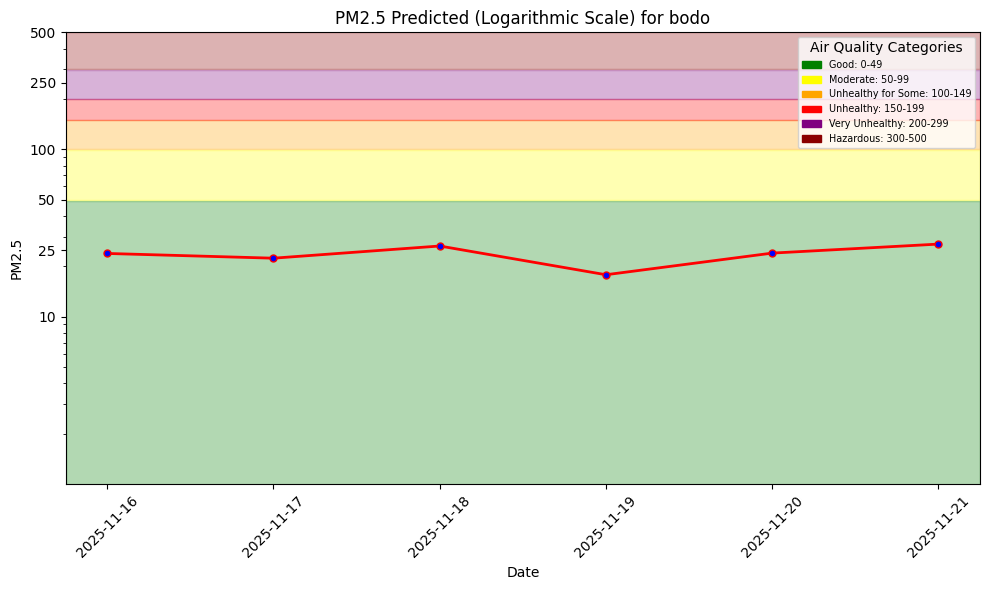

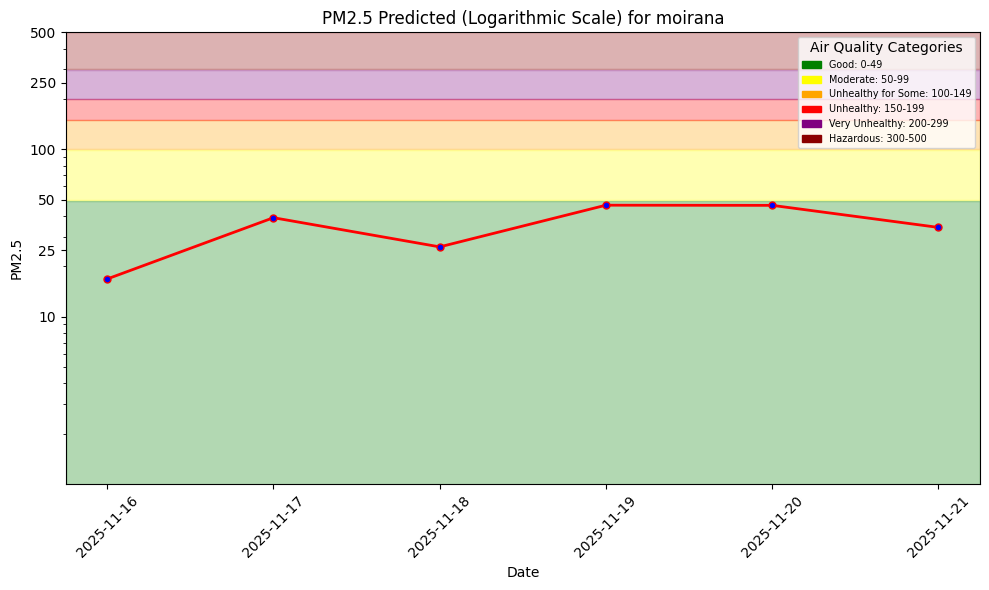

In [15]:
for city in city_dict:
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{city}.png"
    mask = batch_data["city"] == city
    util.plot_air_quality_forecast(city, batch_data.loc[mask], pred_file_path)


In [16]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','days_before_forecast_day'],
    event_time="date"
)

In [17]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 12/12 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279155/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-15 14:43:54,970 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 14:43:58,176 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 14:45:25,043 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-15 14:45:25,590 INFO: Waiting for log aggregation to finish.
2025-11-15 14:45:25,592 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [18]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,days_before_forecast_day
0,2025-11-16 00:00:00+00:00,-3.300000,0.800000,0.804985,243.435013,moirana,16.807016,1.0
1,2025-11-16 00:00:00+00:00,-1.400000,2.000000,8.350138,172.568680,bodo,23.870823,1.0
2,2025-11-13 00:00:00+00:00,-2.243750,0.700000,9.473541,221.859055,moirana,27.214762,1.0
3,2025-11-14 00:00:00+00:00,-0.315000,3.900000,20.542879,347.691315,bodo,13.902066,1.0
4,2025-11-18 00:00:00+00:00,-3.300000,0.300000,6.120000,151.927612,bodo,26.447577,1.0
5,2025-11-17 00:00:00+00:00,-1.800000,0.000000,1.800000,143.130020,bodo,22.365242,1.0
6,2025-11-15 00:00:00+00:00,3.850000,1.500000,25.842384,251.312546,bodo,13.755462,1.0
7,2025-11-21 00:00:00+00:00,-5.000000,0.000000,2.189795,80.537750,moirana,34.157856,1.0
8,2025-11-18 00:00:00+00:00,-4.350000,0.000000,1.835647,11.309896,moirana,26.129618,1.0
9,2025-11-20 00:00:00+00:00,-2.150000,0.300000,7.342588,168.690109,bodo,23.985840,1.0


In [19]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,date,pm25,city,url
0,2025-11-06 00:00:00+00:00,7.0,bodo,https://api.waqi.info/feed/@12706
1,2025-11-04 00:00:00+00:00,6.0,bodo,https://api.waqi.info/feed/@12706
2,2023-08-10 00:00:00+00:00,11.0,bodo,https://api.waqi.info/feed/@12706
3,2023-05-08 00:00:00+00:00,29.0,moirana,https://api.waqi.info/feed/@12698
4,2025-01-14 00:00:00+00:00,23.0,bodo,https://api.waqi.info/feed/@12706
...,...,...,...,...
4205,2022-09-10 00:00:00+00:00,24.0,moirana,https://api.waqi.info/feed/@12698
4206,2020-04-01 00:00:00+00:00,15.0,moirana,https://api.waqi.info/feed/@12698
4207,2020-08-10 00:00:00+00:00,10.0,bodo,https://api.waqi.info/feed/@12706
4208,2025-11-15 00:00:00+00:00,5.0,moirana,https://api.waqi.info/feed/@12698


In [25]:
outcome_df = air_quality_df[['date', 'pm25', 'city']]
preds_df =  monitoring_df[['date', 'predicted_pm25', 'city']]

hindcast_df = pd.merge(preds_df, outcome_df, on=["date","city"])
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    print("test")
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, models, city_dict)
hindcast_df

,date,predicted_pm25,city,pm25
2,2025-11-12 00:00:00+00:00,24.480614,moirana,46.0
3,2025-11-12 00:00:00+00:00,30.819393,bodo,4.0
0,2025-11-13 00:00:00+00:00,27.214762,moirana,17.0
4,2025-11-13 00:00:00+00:00,12.062247,bodo,4.0
1,2025-11-15 00:00:00+00:00,13.755462,bodo,10.0
5,2025-11-15 00:00:00+00:00,16.717487,moirana,5.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

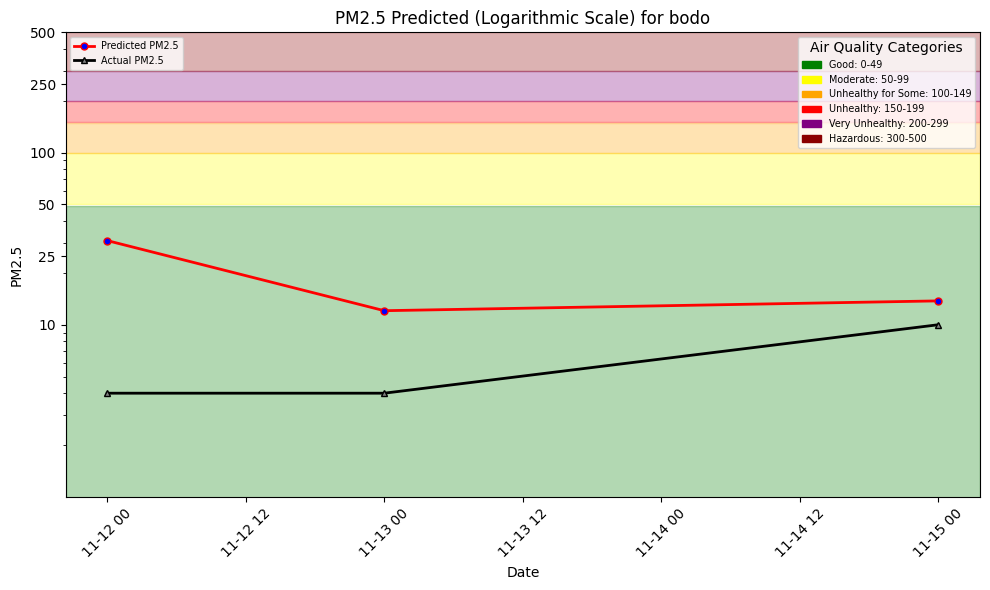

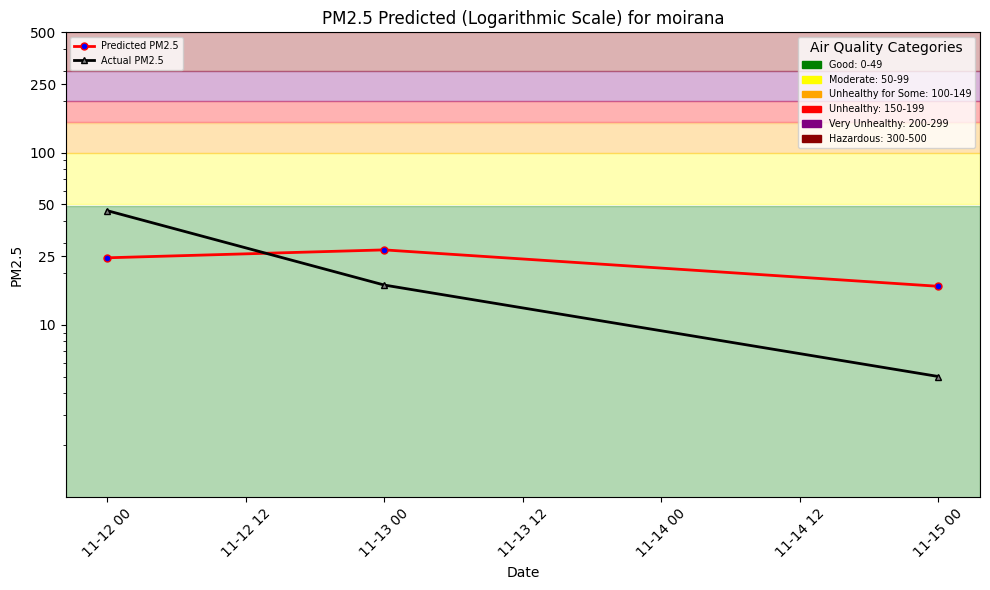

In [27]:
for city in city_dict:    
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{city}.png"
    mask = hindcast_df["city"] == city
    util.plot_air_quality_forecast(city, hindcast_df.loc[mask], hindcast_file_path, hindcast=True)

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [28]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
for city in city_dict:
    dataset_api.upload(f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{city}.png", f"Resources/airquality/{city}_{str_today}", overwrite=True)
    dataset_api.upload(f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{city}.png", f"Resources/airquality/{city}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading c:\Users\lulev\Desktop\KTH\mlfs-book/docs/air-quality/assets/img/pm25_forecast_bodo.png: 0.000%|    …

Uploading c:\Users\lulev\Desktop\KTH\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_bodo.png: 0.000%…

Uploading c:\Users\lulev\Desktop\KTH\mlfs-book/docs/air-quality/assets/img/pm25_forecast_moirana.png: 0.000%| …

Uploading c:\Users\lulev\Desktop\KTH\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_moirana.png: 0.0…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279155/settings/fb/path/Resources/airquality


---